In [1]:
import csv
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from numpy import sqrt
import itertools
from sklearn.datasets import make_swiss_roll
import mpl_toolkits
from mpl_toolkits.mplot3d import Axes3D

# Opening images

In [2]:
img1 = cv2.imread('galaxy.jpg')
img2 = cv2.imread('aurore.jpg')
# Conversion to RGB
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

In [3]:
Y = img1.reshape((-1,3))
# Convert the image into a matrix of floats with all the points
Y = np.float32(Y)

Z = img2.reshape((-1,3))
# Convert the image into a matrix of floats with all the points
Z = np.float32(Z)


[[ 20.  27.  55.]
 [ 31.  38.  66.]
 [ 31.  38.  66.]
 ...
 [ 90. 108. 132.]
 [ 11.  29.  53.]
 [  3.  21.  45.]]


# Functions

In [30]:
def convert_to_float(lst):
    return [float(value) for value in lst]

def algoIsolationForest(data):
    model = IsolationForest(contamination=0.01, random_state=42)
    model.fit(data)
    model.predict(data)
    anomalies = model.predict(data) 
    anomalies_index = [i for i, pred in enumerate(anomalies) if pred == -1]
    anomalies_data_s = [data[i] for i in anomalies_index]

    #anomalies_data = [float(value) for value in anomalies_data_s]
    # Appliquer la conversion récursivement à chaque sous-liste
    anomalies_data = [convert_to_float(sublist) for sublist in anomalies_data_s]
    return anomalies_index, anomalies_data

Indices des anomalies : [11, 121]
Données des anomalies : [[2.0, -6.0, -4.0], [2.0, 2.0, 8.0]]


In [31]:
def replace(data,anomalies_index):
    datamodif = []
    for i in range(0,len(anomalies_index)):
        index = anomalies_index[i]
        datamodif.append(np.array(data[index-1]))
    return datamodif


In [33]:
def replace2(data,anomalies_index):
    datamodif = data
    for i in range(0,len(anomalies_index)):
        index = anomalies_index[i]
        datamodif[index] = data[index-1]
    return datamodif

In [39]:
def find_elbow_point(inertias):
    x1, y1 = 1, inertias[0]
    x2, y2 = len(inertias), inertias[-1]
    distances = []
    for i in range(1, len(inertias) - 1):
        x0, y0 = i + 1, inertias[i]
        distance = np.abs((y2 - y1) * x0 - (x2 - x1) * y0 + x2 * y1 - y2 * x1) / np.sqrt((y2 - y1) ** 2 + (x2 - x1) ** 2)
        distances.append(distance)
    return distances.index(max(distances)) + 2  


In [40]:
def number_of_cluter(X, N):
    K = range(1, N)

    inertias = []
    mapping1 = {}

    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k,n_init='auto').fit(X)
        kmeanModel.fit(X)
        inertias.append(kmeanModel.inertia_)

        mapping1[k] = kmeanModel.inertia_
    return K, inertias, find_elbow_point(inertias)

In [43]:
#calcul distance x1,y1,z1,x2,y2,z2
def distance(list1,list2):   
    x1 = list1[0]; y1 = list1[1]; z1 = list1[2]      
    x2 = list2[0]; y2 = list2[1]; z2 = list2[2]
    d = sqrt((x1-x2)**2+(y1-y2)**2+(z1-z2)**2)
    return d


In [1]:
#calcul diagonale on calcul la distance entre (xmax,ymin,zmin) et (xmin,ymax,zmax)
def diag(Img):
    x = Img[:,0]; y = Img[:,1]; z = Img[:,2]
    xmin = min(x); ymin = min(y); zmin = min(z)
    xmax = max(x); ymax = max(y); zmax = max(z)
    diag = distance([xmax,ymin,zmin],[xmin,ymax,zmax])
    return diag, [[xmax,xmin]],[[ymin,ymax]],[[zmin,zmax]]

In [45]:
def density(Img, alpha):
    x = Img[:,0]; y = Img[:,1]; z = Img[:,2]
    num_points, width = Img.shape[:2]
    D = []
    #index = []
    for i in range (0,num_points):
        Dtemp = 0
        for j in range (0,num_points):
            d = distance([x[i],y[i],z[i]],[x[j],y[j],z[j]])
            if (d <= alpha):
                Dtemp += 1
        D.append(Dtemp)
    return D

In [46]:
def sort(D,k):
    minimum = min(D)
    Dsort = []
    index = []
    for i in range (0,10*k):
        Dsort.append(max(D))
        indextemp = D.index(max(D))
        index.append(indextemp)
        D[indextemp] = minimum
    return Dsort,index

In [21]:
def centroids(Img,index,k):
    comb = itertools.combinations(index, k)
    combarray = [np.array(t) for t in comb]
    n = len(combarray)
    max = 0
    for j in range (0,n):
        comb2 = itertools.combinations(combarray[j],2)
        comb2array = [np.array(t) for t in comb2]
        d = 0
        p = len(comb2array)
        for i in range(0,p):
            d += distance(Img[comb2array[i][0]],Img[comb2array[i][1]])
        if d > max :
            max = d
            centers = combarray[j]
    return centers
            
        
    


In [49]:
def convertindex(Img,index):
    xc = []; yc = []; zc = []
    xc.append(Img[index[0]][0]); xc.append(Img[index[1]][0]); xc.append(Img[index[2]][0])
    yc.append(Img[index[0]][1]); yc.append(Img[index[1]][1]); yc.append(Img[index[2]][1])
    zc.append(Img[index[0]][2]); zc.append(Img[index[1]][2]); zc.append(Img[index[2]][2])
    return xc,yc,zc

    

# Improvement of kmeans

In [28]:
x=[]
y=[]
z = []
data = []

# on ouvre le fichier
with open('data3D.txt', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    for col in reader:
        x.append(float(col[0])) #1st column
        y.append(float(col[1])) #2nd column
        z.append(float(col[2])) #3rd column
        data.append(col)

data_float = np.zeros((len(data),3))
for i in range(0,len(data)):
    data_float[i] = [float(sublist) for sublist in data[i]]

C:\Users\elisa\AppData\Local\Temp\ipykernel_12044\3180758016.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(x, y, z, cmap='viridis')


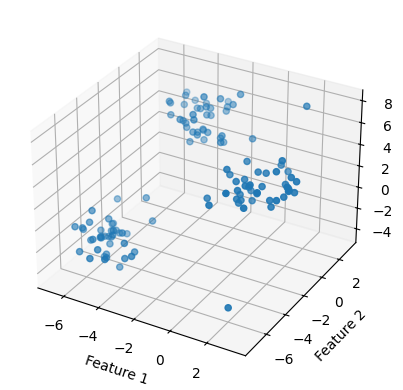

In [29]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, cmap='viridis')
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.show()


In [ ]:
anomalies_index, anomalies_data = algoIsolationForest(data)
# Display the indices and data of anomalies
print("Indices des anomalies :", anomalies_index)
print("Données des anomalies :", anomalies_data)

In [35]:
xa = []
ya = []
za = []
Xtemp = data_float
for i in range(0,len(anomalies_data)):
    Xtemp[anomalies_index[i]] =  Xtemp[anomalies_index[i] - 1]
    xa.append(anomalies_data[i][0])
    ya.append(anomalies_data[i][1])
    za.append(anomalies_data[i][2])


<Figure size 640x480 with 0 Axes>

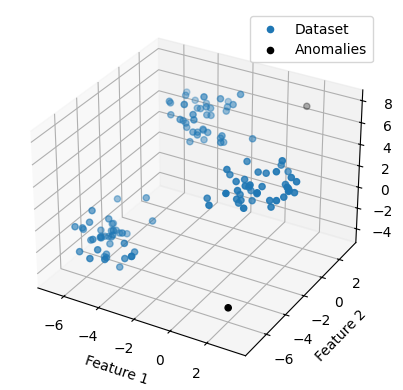

<Figure size 640x480 with 0 Axes>

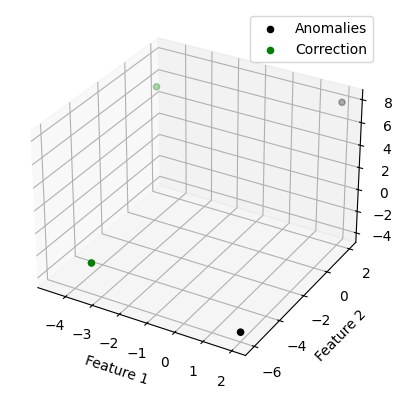

In [36]:
Xmodif = replace(data_float,anomalies_index)
Xmodiftemp = np.zeros((len(Xmodif),3))
for i in range(0,len(Xmodif)):
    Xmodiftemp[i] = Xmodif[i]
Xmodif = Xmodiftemp

plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xtemp[:, 0], Xtemp[:, 1], Xtemp[:, 2], label='Dataset')
ax.scatter(xa, ya, za, color='black', label='Anomalies')
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.legend()
plt.show()

plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.scatter(Xtemp[:, 0], Xtemp[:, 1], Xtemp[:, 2], label='Dataset')
ax.scatter(xa, ya, za, color='black', label='Anomalies')
ax.scatter(Xmodif[:, 0], Xmodif[:, 1], Xmodif[:, 2], color='green', label='Correction')
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.legend()
plt.show()


In [38]:
data_float = replace2(data_float,anomalies_index)

[[-5.93355648 -6.65958196 -2.33723502]
 [-5.69962081 -5.08948849 -2.20694874]
 [-5.65039932 -4.37867944 -2.67284554]
 [-5.52656555 -5.29515761 -1.84926008]
 [-6.36875405 -5.65020464 -1.16589813]
 [-6.14057998 -5.34258221 -0.77854237]
 [-4.45285633 -2.6593851   0.17068472]
 [-6.59081584 -5.98044714 -0.89357814]
 [-4.90062123 -7.35433313 -1.86284755]
 [-6.7763586  -4.94073975 -2.09907717]
 [-3.29924882 -6.0882798  -1.92143368]
 [-3.29924882 -6.0882798  -1.92143368]
 [-6.15118547 -3.93121087 -3.27353233]
 [-3.92041251 -5.71961023 -1.33097134]
 [-5.76520022 -3.82457125 -1.98978934]
 [-5.74334143 -3.95828891 -2.52791241]
 [-6.04669643 -3.26221388 -2.54599332]
 [-4.55132672 -5.17769371 -4.35621109]
 [-4.85128584 -5.21509455 -1.01613089]
 [-4.95060333 -5.75474778 -3.17699332]
 [-5.14253057 -4.81282474 -1.93009   ]
 [-6.15163599 -5.26067633 -2.53351081]
 [-3.79520049 -5.91311975 -2.52523928]
 [-3.93972091 -2.94596814 -1.53400248]
 [-6.09802697 -5.14644182  0.17279623]
 [-6.05797951 -4.44277502

3


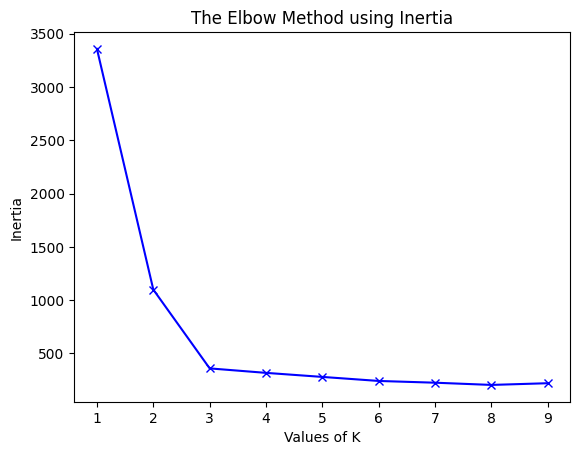

In [41]:
# Create a range of values for k
N = 10
K, inertias, optimal_k = number_of_cluter(data_float, N)

print(optimal_k)
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

3


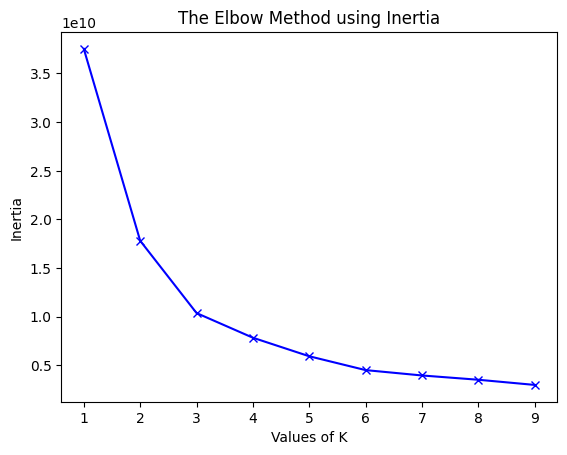

In [15]:
Kimg, inertiasimg, optimal_kimg = number_of_cluter(Z, N)

print(optimal_kimg)
plt.plot(Kimg, inertiasimg, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

In [42]:
elbow = find_elbow_point(inertias)
print(elbow)

3


<Figure size 640x480 with 0 Axes>

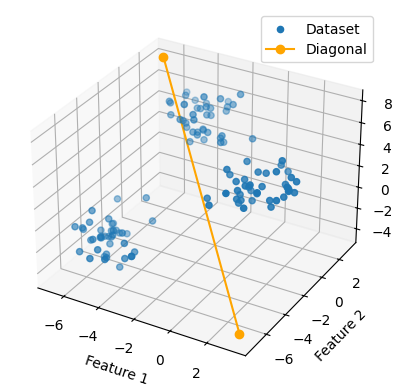

In [47]:
k = 3
diagonal, xp, yp, zp = diag(data_float)

plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_float[:, 0], data_float[:, 1], data_float[:, 2], label='Dataset')
ax.plot(xp[0], yp[0], zp[0], color='orange', marker='o', label='Diagonal')
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.legend()
plt.show()


In [48]:
alpha = diagonal/k
D = density(data_float,alpha)
Dsort,index = sort(D,k)
centers = centroids(data_float,index,k)
print(index)
print(centers)

[99, 109, 110, 119, 44, 95, 112, 64, 41, 76, 60, 61, 70, 66, 83, 92, 6, 57, 62, 71, 87, 88, 91, 52, 85, 75, 90, 94, 49, 53]
[ 6 71 85]


<Figure size 640x480 with 0 Axes>

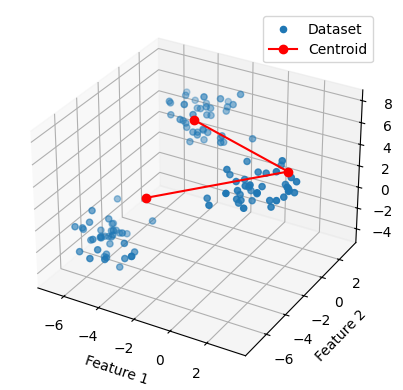

In [52]:
xc,yc,zc = convertindex(data_float,centers)

plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data_float[:, 0], data_float[:, 1], data_float[:, 2], label='Dataset', zorder=1)
ax.plot(xc, yc, zc, color='red', marker='o', label='Centroid', zorder=1000)
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.set_zlabel("Feature 3")
plt.legend()
plt.show()